In [58]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt

import Project_library as pl

## Auto Regressive model for data demand change

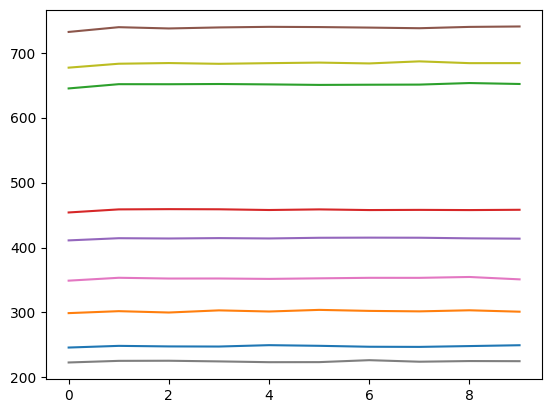

In [36]:
def ar1_process(demand_over_time: jnp.ndarray, variability : float, time_slots : int, ar_weight : float, key : jnp.ndarray) -> jnp.ndarray:
    white_noise = jrandom.normal(key, demand_over_time.shape)  # Generate white noise

     # Add the initial demand to the white noise

    for i in range(1, time_slots):
        demand_over_time = demand_over_time.at[i].set(ar_weight * demand_over_time[i-1] + white_noise[i]+ demand_over_time[0])

    return demand_over_time


# Demanded bit rate changes with time
# Demand is intialised
for k in range(1, 10):
    demand = jnp.array([jrandom.randint(jrandom.PRNGKey(k), (1), minval=200, maxval = 750)])
    
    # The reconfiguration period is 30 seconds
    reconfiguration_period = 30
    # The number of reconfigurations is 10
    time_slots = 10

    time_slot_duration =int( reconfiguration_period / time_slots)

    # Setup array with demand over time
    demand_over_time = jnp.zeros((time_slots, demand.shape[0]))

    demand_over_time = demand_over_time.at[0].set(demand[0].item())

    #print(demand_over_time)

    key, subkey = jrandom.split(jrandom.PRNGKey(k))
    # Calculate the AR(1) process for the demand

    demand_over_time = ar1_process(demand_over_time, 1, time_slots, 0.01, subkey)

    plt.plot(demand_over_time)

## Markov Distribution

In [48]:
def markov_step(state, key, A):
    key, subkey = jrandom.split(key)
    probs = A[state]  # Transition probabilities from current state
    next_state = jrandom.choice(subkey, A.shape[0], p=probs)
    return next_state, next_state

# Function for state change given A
def user_state_change(state_change_matrix : jnp.ndarray, state : int, time_series : jnp.ndarray, key : jnp.ndarray) -> jnp.ndarray:
    # Create a copy of the state change matrix

    key = jrandom.split(key, time_series.shape[0]-1)

    def scan_fn(state,key):
        return markov_step(state, key, state_change_matrix)

    _, states = jax.lax.scan(scan_fn, state, key)

    return jnp.concatenate([jnp.array([state]), states])

seed = 42

key = jrandom.PRNGKey(seed)

time_series = jnp.zeros((time_slots, 1))
# Create a state change matrix

state_change_matrix = jnp.array([[0.1, 0.9], 
                                 [0.3, 0.7]])

# Intial state is 0
state = 0
time_series = user_state_change(state_change_matrix, state, time_series, key)

time_series, time_series.shape[0]

(Array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1], dtype=int32), 10)

In [54]:
seed = 10

key = jrandom.PRNGKey(seed)
# Number of users in a cell
num_users = jrandom.choice(key, jnp.arange(10,20))

user_rate = 100e3 # 100 kbps

time_series = jnp.zeros((time_slots, 1))

series = []

# Loop over the number of users, can compute the demand based on the state change of the users.
for i in range(num_users):
    key, subkey = jrandom.split(key)
    # Create a state change matrix
    state_change_matrix = jnp.array([[0.3, 0.7], 
                                     [0.3, 0.7]])
    # Intial state is 1
    state = 1
    series.append(user_state_change(state_change_matrix, state, time_series, key))

series

[Array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0], dtype=int32),
 Array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int32),
 Array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0], dtype=int32),
 Array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1], dtype=int32),
 Array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1], dtype=int32),
 Array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1], dtype=int32),
 Array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0], dtype=int32),
 Array([1, 0, 1, 0, 1, 1, 1, 0, 1, 1], dtype=int32),
 Array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32),
 Array([1, 1, 0, 1, 1, 0, 1, 0, 0, 1], dtype=int32),
 Array([1, 1, 1, 0, 1, 1, 0, 0, 1, 0], dtype=int32),
 Array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0], dtype=int32),
 Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)]

Text(0.5, 1.0, 'Demand Over Time')

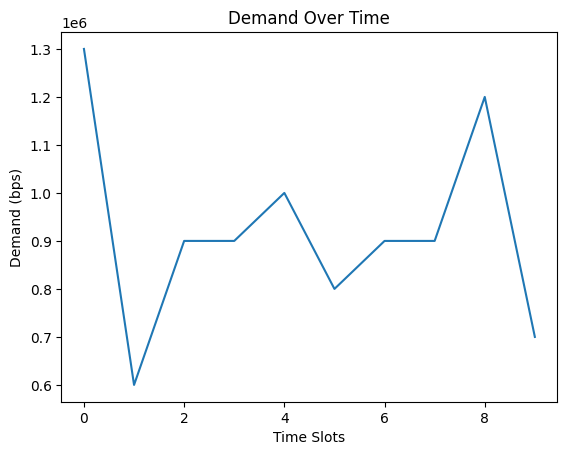

In [57]:
# Sum along the columns to get the total demand
total_demand = jnp.sum(jnp.array(series), axis=0)
total_demand = total_demand.flatten()*100e3

total_demand
# Plot the demand over time
plt.plot(total_demand, label='Total Demand')
plt.xlabel('Time Slots')
plt.ylabel('Demand (bps)')
plt.title('Demand Over Time')

In [ ]:
earth_radius = 6371  # in kilometers

satellite_height = 600  # in meters

# Place a satellite at the
satellite_position = jnp.array([0, 0, satellite_height + earth_radius])  # in kilometers

# Calculate the viewing angle
pl.